# MRI QA Summary Reports

In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from mriqa.dcmio import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    resolution_bars_report, uniformity_report, snr_report
)

## Slice Profile

The TO2 phantom has two crossed plates and two pairs of wedges. Here we use the two crossed plates to estimate the full-width half maximum of the slice profile for 5mm and 3mm slices as described in the IPEM *green book*.

To go from the width of the profile in the image to the true width we need to scale by the tangent of the plate angle which here we take to be 11.7&deg;.

So as to facilitate the analysis we interpolate the images to higher resolution first. Having extracted the thick profiles we fit a quadratic bias to the start and the end of the profile assuming this is outside of the plate and is just the gain field for the background liquid in the phantom. We divide the profiles by this modelled gain variation and also invert them to give a positive going *line shape*.

This is fitted using cubic splines and the half height position found to determine the FWHM which is then scaled appropriately for pixel size and plate projection.

Although we correct for non-uniformity below, it is better to use prescan normalised images to limit the bias field in the background of the image.

### 3 mm Slice

In [2]:
# TO2: Slice 3mm
patid = 'PQA20160129RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[30])
slice_idx = 2
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

Plate Angle  =  11.7 degrees
FWHM     (1) =  59.4 pixels, or 3.0 mm
FWHM     (2) =  57.6 pixels, or 2.9 mm
FWHM (GMEAN) =  58.5 pixels, or 3.0 mm


### 5 mm Slice

In [3]:
# TO2: Slice 5mm
patid = 'PQA20160129RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[28])
slice_idx = 0
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)
results = results.append(result)

Plate Angle  =  11.7 degrees
FWHM     (1) =  89.8 pixels, or 4.5 mm
FWHM     (2) =  103.3 pixels, or 5.2 mm
FWHM (GMEAN) =  96.3 pixels, or 4.9 mm


In [4]:
results[['FWHMGMeanPixels', 'FWHMGMeanMM']]

FWHMGMeanPixels  FWHMGMeanMM
SliceThickness                              
3                     58.483793     2.956888
5                     96.301485     4.868916

## Geometric Distortion and Scaling

The TO2 phantom has a 120mm square box for distortion measurements. Here we use this to estimate the in plane scale (aka *linearity*) and the relative distortion as described in the IPEM Report 80 *green book*. It is best to use the thinner 3mm slice series for this to minimise the blurring from misalignment. We choose a slice in the middle of the block.

In addition, if scans are available at 512x512 rather than 256x256 this will allow more accurate determination of the distortion but note that in this case the bandwidth should be scaled down by a factor of two so as to obtain the same sensitivity to off-resonance distortion. The scans should be acquired with the phase encoding direction both along columns and along rows to separate out off-resonance effects from the gradient spatial non-linearity.

After centring the phantom we extract an ROI for the box using its expected position in the phantom. The central area is occupied by the wedges and plates so we fill this with the phantom background intensity so it doesn't interfere with profiles across the ROI.

Then, to get smoother and more easily locatable peaks in the profiles, we interpolate the image to higher resolution using the `scipy.ndimage` image `zoom` function. 

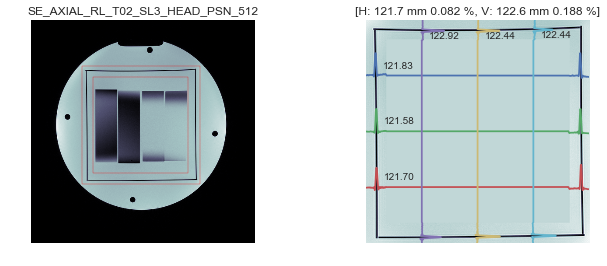

Horizontal Distances:     [121.826171875, 121.58203125, 121.7041015625] (mm)
Scale (Horizontal):       121.7 mm
Distortion (Horizontal):  0.08 %
Vertical Distances:       [122.9248046875, 122.4365234375, 122.4365234375] (mm)
Scale (Vertical):         122.6 mm
Distortion (Vertical):    0.19 %


In [5]:
# TO2: Distortion
# SE: Axial, Phase RL, 512 matrix
patid = 'PQA20160129RHD'
stuid = '1'
dobjs = fetch_series(patid, stuid, sernos=[29])

slice_idx = len(dobjs)//2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

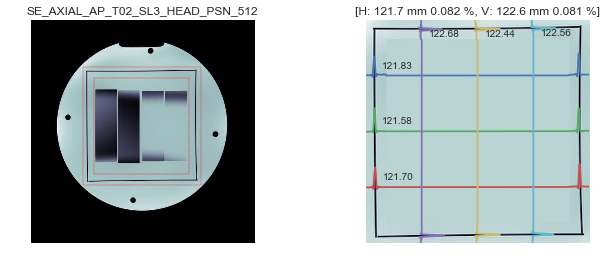

Horizontal Distances:     [121.826171875, 121.58203125, 121.7041015625] (mm)
Scale (Horizontal):       121.7 mm
Distortion (Horizontal):  0.08 %
Vertical Distances:       [122.6806640625, 122.4365234375, 122.55859375] (mm)
Scale (Vertical):         122.6 mm
Distortion (Vertical):    0.08 %


In [6]:
# TO2: Distortion
# SE: Axial, Phase AP, 512 matrix
patid = 'PQA20160129RHD'
stuid = '1'
dobjs = fetch_series(patid, stuid, sernos=[31])

slice_idx = len(dobjs)//2
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False))

In [7]:
results[['Orientation', 'PhaseDirection', 'Sensitivity', 'HorizontalScale', 'HorizontalDistortion','VerticalScale', 'VerticalDistortion' ]]

Orientation PhaseDirection  Sensitivity  HorizontalScale  \
Series                                                            
29           Axial             RL     0.462955       121.704102   
31           Axial             AP     0.462955       121.704102   

        HorizontalDistortion  VerticalScale  VerticalDistortion  
Series                                                           
29                  0.081895     122.599284            0.187748  
31                  0.081895     122.558594            0.081324

## Spatial Resolution

The resolution is assessed using the TO4 phantom, which has parallel plates of various separations as well as MTF blocks. Here we'll just use the plates. As it is very difficult to align the phantom so that the plates are exactly along a pixel axis we automatically realign the images before projecting along the plate direction to give an average profile across the plates. We present the results for the highest resolution scan (1024x10124).

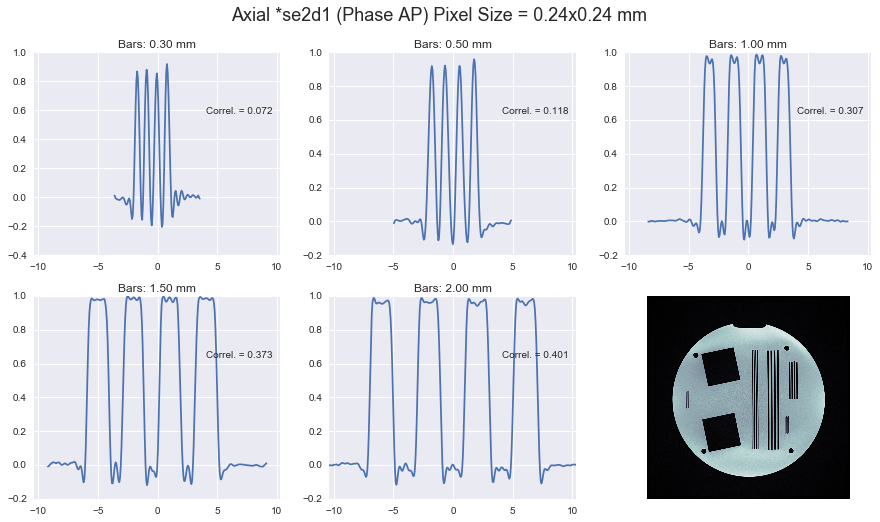

In [8]:
# TO4: Resolution
patid = 'PQA20160129RHD'
stuid = '1'

dobjs = fetch_series(patid, stuid, sernos=[38])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=True)

## Ghosting

To test for image ghosting we follow the approach of the [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) and look for image intensity outside a symmetrically positioned phantom. This is sensitive to Nyquist ghosting in EPI scans and scattered ghosts due to phase instabilities in fast spin echo. We present the values here for the transverse orientation.

### Spin Echo

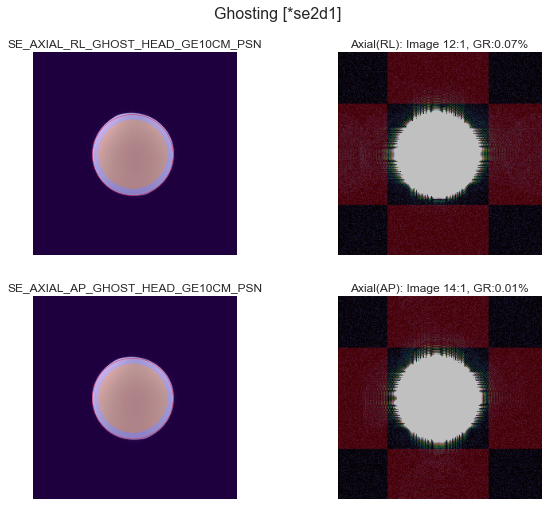

In [9]:
# GE10CM: Ghosting
patid = 'PQA20160129RHD'
stuid = '1'
# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [12, 14]]
results = ghosting_report(dobjs)

### Fast Spin Echo

In [10]:
# GE10CM: Ghosting
# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [16, 18]]
results = results.append(ghosting_report(dobjs))

### EPI

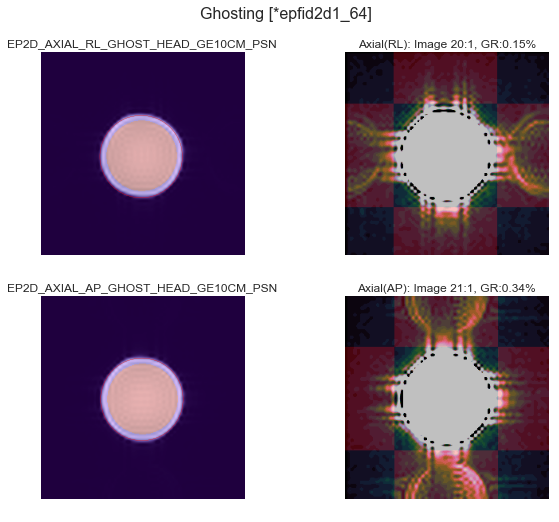

In [11]:
# GE10CM: Ghosting
# EPIFID64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [20, 21]]
results = results.append(ghosting_report(dobjs))

### Spin Echo EPI

In [12]:
# GE10CM: Ghosting
# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [22, 24]]
results = results.append(ghosting_report(dobjs))

In [13]:
display(results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

Sequence Orientation PhaseDirection  GhostRatio
Series                                                     
12            *se2d1       Axial             RL    0.069945
14            *se2d1       Axial             AP    0.014556
16        *tse2d1_18       Axial             RL    0.284792
18        *tse2d1_18       Axial             AP    0.098011
20      *epfid2d1_64       Axial             RL    0.150558
21      *epfid2d1_64       Axial             AP    0.344383
22      *epse2d1_128       Axial             RL    0.711461
24      *epse2d1_128       Axial             AP    2.220081

## Receiver Coil Uniformity

We test the uniformity of the head coil (either the standard coil or the advanced neuro depending on what is normally used). We use normally use a silicone oil filled spherical phantom so as to avoid B<sub>1+</sub> shading effects at 3T. Here we have used a gel phantom as the field strength is only 1.5T. We obtain images both with and without prescan based intensity normalisation (this can be done in a single acquisition on Siemens systems). The analysis is based on the green book method. Results are presented both before and after `prescan-normalise` intensity correction.

In [14]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
patid = 'PQA20160129RHD'
stuid = '1'

raw_tra = fetch_series(patid, stuid, sernos=[3])
psn_tra = fetch_series(patid, stuid, sernos=[4])
raw_sag = fetch_series(patid, stuid, sernos=[5])
psn_sag = fetch_series(patid, stuid, sernos=[6])
raw_cor = fetch_series(patid, stuid, sernos=[7])
psn_cor = fetch_series(patid, stuid, sernos=[8])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

In [15]:
print('Raw Images')
display(results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']])
print('Intensity Normalised Images')
display(results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']])

Raw Images


SeriesRaw                        ProtocolRaw    OrientRaw  \
Axial             3  SE_AXIAL_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal           7    SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal          5    SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

          XUniformityRaw  YUniformityRaw  
Axial          34.567901       49.681529  
Coronal        32.919255       29.936306  
Sagittal       47.770701       27.215190

Intensity Normalised Images


SeriesNorm                       ProtocolNorm   OrientNorm  \
Axial              4  SE_AXIAL_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal            8    SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal           6    SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

          XUniformityNorm  YUniformityNorm  
Axial           75.155280        93.630573  
Coronal         81.875000        87.341772  
Sagittal        88.535032        87.261146

## Signal to Noise Ratio

We test the signal to noise ratio of the head coil (either the standard coil or the advanced neuro depending on what is normally used). We use the Siemens long bottle phantom as this has a holder allowing it to be reproducibly positioned.

We take a single value for the image noise obtained from the standard deviation of the difference image. This assumes that the noise is spatially uniform, which is probably reasonable if there has been no intensity normalization or non-linear filtering. We consider only the region outside the phantom for this so as to minimise the effect of subtraction artefacts within the phantom.

In addition, as the noise uniformity may also dependent on any non-linearity in the the coil combination method we use only the basic sum of squares mode rather than the Siemens *adaptive* recombination.

The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. 

In [16]:
# LONGBOTTLE: Signal to Noise
patid = 'PQA20160129RHD'
stuid = '1'
raw_tra = fetch_series(patid, stuid, sernos=[10])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])

In [17]:
print('SNR: Raw Images')
display(results)

SNR: Raw Images


HEA;HEP
0.50  539.789519
0.75  660.433549

There's something wrong with the subtraction image. There seems to be a fixed offset which suggests that the gain changed between the acquisitions - check we have centred the colour map properly. 